In [9]:
%matplotlib

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from neuralop.losses.finite_diff import central_diff_2d

from torch.utils.data import DataLoader, TensorDataset
from neuralop.models import FNO, FNO_modified
from datetime import datetime
from tqdm import tqdm
import os
import time

from utils.generate_data import *

from IPython.display import HTML

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Using matplotlib backend: module://matplotlib_inline.backend_inline


The source code of neuralop is modified. To make this work, replace the file "fno.py" with the one found in the git repo.

Take the file fno.py from "./library changes/" and replace it with the file below.

C:\Users\USERNAME\AppData\Local\miniconda3\envs\torchcfm\Lib\site-packages\neuralop\models\fno.py

In [16]:
save_dir = "saved_simulations"
os.makedirs(save_dir, exist_ok=True)
os.getcwd()

'/data/BioGrid/gouwenss/surrogate-spr'

In [12]:
# f.split('_')[-2] + '_' + f.split('_')[-1].split('.')[0]

In [26]:
# latest_files = {}
# for f in os.listdir(save_dir):
#     timestamp_str = f.split('_')[-2] + '_' + f.split('_')[-1].split('.')[0]
#     timestamp = datetime.strptime(timestamp_str, "%Y%m%d_%H%M%S")

#     if f.startswith('FNO_model'):
#         key = 'FNO_model'
#     elif f.startswith('pde_data_input_output'):
#         key = 'pde_data_input_output'

#     if key not in latest_files or timestamp > latest_files[key][1]:
#         latest_files[key] = (f, timestamp)

# latest_filenames = {k: v[0] for k, v in latest_files.items()}

latest_filenames = {"FNO_model": "FNO_model_modes16x16_width64_layers4_modified.pt"}
print(f"Latest parameter set is stored in {latest_filenames['FNO_model']}")

Latest parameter set is stored in FNO_model_modes16x16_width64_layers4_modified.pt


<!-- Fitting a Fourier Neural Operator (FNO) to image time-series appears to be quite simple. Given multiple simulations of a Darcy Flow, the model can predict well on an unseen initial situation. However, in our setting we fit a model that is at the same time able to incoorporate (p amount) additional (sensitivity) parameters. The current, most logical architecture is a CNN. However, combining image data and parametric data in a single model is not trivial, and is possible in multiple ways. 

In our application, images can be up to 100 by 100

Below we discuss a few methods:

1) Flatten the image (to 10000 dimensions) and concatenate the parameters (to 10000+p dimensions), apply a fully connected layer that reduces to 100000 dimensions, unflatten to 100x100.
2) Take each parameter, turn it into a p 100x100 images of constant value and add the p layers to the original input. Proceed as follows (but maintaining a suitable number of layers)
3) More elegantly; When given as input p parameters, we can introduce another (FCN) network that maps from ${\Bbb R}^p\to {\Bbb R}^h$ where $h$ is a hidden number of parameters. Then this is reshaped to suit the concept of (2) -->

In [23]:
num_simulations = 50 # 200
frames = 18

input, output, parameters = generate_pde_solutions(num_simulations, frames)
input = input.unsqueeze(1)
output = output.unsqueeze(1)

dataset = TensorDataset(input, output, parameters)
train_loader = DataLoader(dataset, batch_size=16, shuffle=True)
# test_loader = train_loader

test_loader = 0

input.shape, output.shape, parameters.shape, parameters.min(), parameters.max()

(torch.Size([900, 1, 64, 64]),
 torch.Size([900, 1, 64, 64]),
 torch.Size([900]),
 tensor(0.0375),
 tensor(0.0423))

Below the original training loop is found. Note that this is all captured in the the file PDE_FNO_Solver.py

Note that the full model training is done on GPU in the file _fitting-fno-models.ipynb_

In [39]:
# hidden_channels is nu widht=64. Maar het moet input channels + nog wat zijn omdat het de eerste laag is
# De batch_size is nu 16, dus 16 parameters worden geladen, dit willen we niet. Want dit wordt nu per huidige constructie omgerekend tot 16 channels

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# FNO Model Parameters
my_config = {
    'modes_x': 16,
    'modes_y': 16,
    'width': 64,
    'num_layers': 4,
    'activation': 'gelu',
    'batch_size': 16,
    'learning_rate': 1e-4,
    'epochs': 5, # fine-tuning the previously trained model (note, no pretrained model has been downloaded)
    'num_simulations': 1000,
    'frames': 18,
    'save_dir': "saved_simulations",
    'use_modified_fno': True,
    'input_param_dim': 1,
    'hidden_param_dim': 8
}

model = FNO_modified(
    in_channels=1,
    out_channels=1,
    input_param_dim=1,  # Added by Sigur: The number of additional (sensitivity parameters that are added)
    hidden_param_dim=16, # Added by Sigur: The added parameters are first transformed in a separate NN with a hidden dimension.
    n_modes=(my_config['modes_x'], my_config['modes_y'] ), # Number of Fourier modes to keep in x- and y-direction
    hidden_channels=my_config['width'],
    num_layers=my_config['num_layers'],
    activation=my_config['activation']
).to(DEVICE)

# Load saved parameters into model
weights_dir = f"{save_dir}/{latest_filenames['FNO_model']}"
model.load_state_dict(torch.load(
    weights_dir, 
    weights_only=False, 
    map_location=torch.device('cpu'))
)

print(f"Number of parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

optimizer = torch.optim.Adam(model.parameters(), lr=my_config['learning_rate'])
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=my_config['learning_rate'],
                                                steps_per_epoch=len(train_loader), epochs=my_config['epochs'])
criterion = nn.MSELoss()

Number of parameters: 2413699


<!-- The network specifications of the FNO are easily adjusted, however, they do lack flexibility. Ultimately, we wish to incorporate extra parameters into the FNO architecture. To do this, we may need to adjust the FNO function. -->

We adjust the original training loop to make it work with the adjusted network architecture

Check if the parameters are taken up well by the algorithm. Perhaps some print staments on a 1 epoch (1 batch?) network will work.

In [40]:
train_losses = []
test_losses = []

for epoch in range(my_config['epochs']):
    
    model.train()
    running_loss = 0.0
    test_loss = 0.0
    start_time = time.time()

    train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1}/{my_config['epochs']}", leave=True) ##

    for batch_idx, (inputs, targets, param) in enumerate(train_loader_tqdm):
        inputs, targets, param = inputs.to(DEVICE), targets.to(DEVICE), param.to(DEVICE)

        param = param.unsqueeze(1) # Should fix the channel issue

        optimizer.zero_grad()
        outputs = model(inputs, param)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        scheduler.step()

        running_loss += loss.item()

        train_loader_tqdm.set_postfix(loss=f"{loss.item():.6f}")

    epoch_duration = time.time() - start_time
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Computing testing error
    model.eval()
    with torch.no_grad():
        for batch_idx, (inputs, targets, param) in enumerate(train_loader): ### TEST LOADER NEEDS FIX !!!!
            inputs, targets, param = inputs.to(DEVICE), targets.to(DEVICE), param.to(DEVICE)
            param = param.unsqueeze(1)
            outputs = model(inputs, param)
            test_loss += criterion(outputs, targets).item()

    avg_test_loss = test_loss / len(train_loader) ### TEST LOADER
    test_losses.append(avg_test_loss)

    epoch_duration_test = time.time() - start_time

    print(f"Epoch {epoch+1}/{my_config['epochs']}, Train Loss: {avg_train_loss:.6f}, "
          f"Test Loss: {avg_test_loss:.6f}, "
          f"Epoch Time: {epoch_duration:.2f} sec"
          f"Epoch Time (+testing): {epoch_duration_test:.2f} sec"
          )

Epoch 1/5:   0%|          | 0/57 [00:00<?, ?it/s]/mnt/scratch_dir/gouwenss/conda/envs/torchcfm/lib/python3.10/site-packages/tltorch/factorized_tensors/factorized_tensors.py:66: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:306.)
  return self.__class__(self.tensor[indices])
/mnt/scratch_dir/gouwenss/conda/envs/torchcfm/lib/python3.10/site-packages/neuralop/layers/spectral_convolution.py:468: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error 

Epoch 1/5, Train Loss: 0.000012, Test Loss: 0.000009, Epoch Time: 548.40 secEpoch Time (+testing): 717.50 sec


Epoch 2/5: 100%|██████████| 57/57 [08:57<00:00,  9.43s/it, loss=0.000005]


Epoch 2/5, Train Loss: 0.000011, Test Loss: 0.000005, Epoch Time: 537.51 secEpoch Time (+testing): 697.90 sec


Epoch 3/5: 100%|██████████| 57/57 [08:38<00:00,  9.10s/it, loss=0.000003]


Epoch 3/5, Train Loss: 0.000004, Test Loss: 0.000005, Epoch Time: 518.59 secEpoch Time (+testing): 681.49 sec


Epoch 4/5: 100%|██████████| 57/57 [09:27<00:00,  9.95s/it, loss=0.000002]


Epoch 4/5, Train Loss: 0.000003, Test Loss: 0.000003, Epoch Time: 567.32 secEpoch Time (+testing): 738.22 sec


Epoch 5/5: 100%|██████████| 57/57 [07:00<00:00,  7.37s/it, loss=0.000005]


Epoch 5/5, Train Loss: 0.000003, Test Loss: 0.000003, Epoch Time: 420.28 secEpoch Time (+testing): 584.30 sec


In [44]:
mse_identity = torch.mean((input - output)**2)
print(f"The identity mapping would result in a loss of {mse_identity:.7f}, and the models performance is {train_losses[-1]:.7f}")

The identity mapping would result in a loss of 0.0001611, and the models performance is 0.0000028


Below we will load the NPK-PUFF data and try to process it.

In [ ]:
# Timestamp or experiment ID
# timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
# data_file = f"{save_dir}/pde_data_input_output_{timestamp}.pt"
# model_file = f"{save_dir}/FNO_model_modes{y_config['modes_x']}x{y_config['modes_y']}_width{y_config['width']}_layers{y_config['num_layers']}_{timestamp}.pt"

# Save input/output data and model parameters
# torch.save({'input': input, 'output': output}, data_file)

# torch.save(model.state_dict(), model_file)

<!-- Model is fitted, check accuracy on a new data sample -->

In [45]:
input_new, _ , params_new = generate_pde_solutions(1, frames, set_seed=False)

input_new = input_new.unsqueeze(1).unsqueeze(1)
params_new = params_new.unsqueeze(1).unsqueeze(1)

input_new_modeled = input_new.detach().clone()

with torch.no_grad():
    for i in range(frames-1):

        input_new_modeled[i+1] = model(input_new_modeled[i], params_new[0])

input_new = input_new.squeeze(1).squeeze(1)
input_new_modeled = input_new_modeled.squeeze(1).squeeze(1)
input_error = 10*(input_new - input_new_modeled)

# In the training data, the parameter is trained for values ranging between nu = 0 and 0.05
print(f"This simulation has an error of parameter of nu = {params_new.min():.4f}")

/mnt/scratch_dir/gouwenss/conda/envs/torchcfm/lib/python3.10/site-packages/tltorch/factorized_tensors/factorized_tensors.py:66: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:306.)
  return self.__class__(self.tensor[indices])
/mnt/scratch_dir/gouwenss/conda/envs/torchcfm/lib/python3.10/site-packages/neuralop/layers/spectral_convolution.py:468: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /p

This simulation has an error of parameter of nu = 0.0408


In [46]:
# Set up the figure with two subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6), constrained_layout=True)
ax1.set_title("u(t) - Input")
ax2.set_title("u(t+Δt) - Output")

cmap_input = ax1.imshow(input_new[0], extent=[0, 64, 0, 64], origin="lower", cmap="plasma")
cmap_output = ax2.imshow(input_new[0], extent=[0, 64, 0, 64], origin="lower", cmap="plasma")
cmap_error = ax3.imshow(input_new[0], extent=[0, 64, 0, 64], origin="lower", cmap="plasma")

fig.colorbar(cmap_input, ax=ax1, shrink=0.75)
fig.colorbar(cmap_output, ax=ax2, shrink=0.75)
fig.colorbar(cmap_output, ax=ax3, shrink=0.75)

for ax in (ax1, ax2, ax3):
    ax.set_xticks([])
    ax.set_yticks([])

def update(frame):
    cmap_input.set_data(input_new[frame])
    cmap_output.set_data(input_new_modeled[frame])
    cmap_error.set_data(input_error[frame])

    ax1.set_title(f"Ground truth, Frame {frame}")
    ax2.set_title(f"Fourier Neural Net, Frame {frame}")
    ax3.set_title(f"Error of model (*10), Frame {frame}")

    return cmap_input, cmap_output, cmap_error

ani = animation.FuncAnimation(fig, update, frames=frames, interval=frames, blit=False)
display(HTML(ani.to_jshtml()))
plt.close(fig)

# ani.save("saved_animations/simulation.mp4", writer='ffmpeg', fps=10)

# Model performance

Can we say anything about the error between nu = 0 and nu = 0.05?

In [184]:
num_sims = 100
input_new, _ , params_new = generate_pde_solutions(num_sims, frames, set_seed=True)
input_new = input_new.unsqueeze(1).unsqueeze(1)
params_new = params_new.unsqueeze(1).unsqueeze(1)

input_new_modeled = input_new.detach().clone()

with torch.no_grad():
    # num_of_sim amount of simutions are made, each with their own value of nu.
    # For each simulation, we also perform the simulation using the trained FNO
    # We see how different they are, given their value of nu.
    model(input_new_modeled[0], params_new[0])

    for sim in range(num_sims):
        frame_index = range(sim*frames, (sim+1)*frames-1)

        for frame in frame_index:
            input_new_modeled[frame+1] = model(input_new_modeled[frame], params_new[frame])

Text(0.5, 1.0, 'The MSE in the last frame after applying model iteratively')

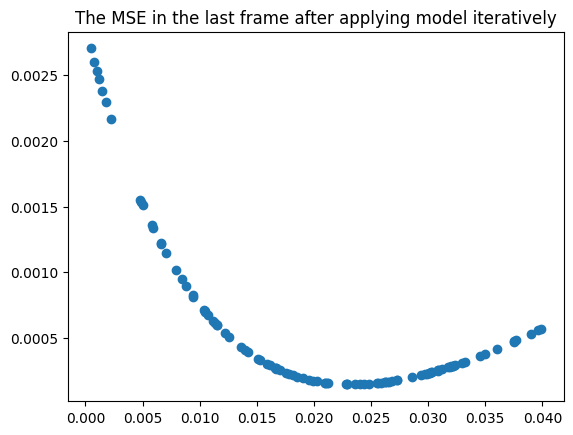

In [ ]:
endpoints_simulations_idx = range(frames-1,frames*num_sims, frames)

endpoints_simulations = input_new[endpoints_simulations_idx]
endpoints_sim_predict = input_new_modeled[endpoints_simulations_idx]
params_new = params_new[endpoints_simulations_idx]

mse_endpoint_prediction = endpoints_simulations - endpoints_sim_predict
mse_endpoint_prediction = torch.mean(mse_endpoint_prediction**2, dim=(1,2,3,4))

plt.scatter(params_new, mse_endpoint_prediction)
plt.title("The MSE in the last frame after applying model iteratively")

The question that pops up is how a network would have performed if the original network was used with fixed sensitivity parameters.

# Comparison with the original FNO model at fixed sensitivity parameters

In [ ]:
num_simulations = 1300 # 200
frames = 18

nu_value = 0.02

input, output, parameters = generate_pde_solutions_old(num_simulations, frames, set_seed=False, nu=nu_value)
input = input.unsqueeze(1)
output = output.unsqueeze(1)

dataset = TensorDataset(input, output, parameters)
train_loader = DataLoader(dataset, batch_size=16, shuffle=True)

test_loader = 0

input.shape, output.shape, parameters.shape, parameters.min(), parameters.max()

In [ ]:
EPOCHS = 30 # Reduced for quicker demonstration, increase for better results
save_dir_no_par = f"{save_dir}_no_par"

model_no_par = FNO(
    in_channels=1,
    out_channels=1,
    n_modes=(MODES_X, MODES_Y),
    hidden_channels=WIDTH,
    num_layers=NUM_LAYERS,
    activation=ACTIVATION
).to(DEVICE)

# Load saved parameters into model
# weights_dir = f"{save_dir_no_par}/{latest_filenames['FNO_model']}"
# model_no_par.load_state_dict(torch.load(weights_dir, weights_only=False))

print(f"Number of parameters: {sum(p.numel() for p in model_no_par.parameters() if p.requires_grad)}")

optimizer = torch.optim.Adam(model_no_par.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LEARNING_RATE,
                                                steps_per_epoch=len(train_loader), epochs=EPOCHS)
criterion = nn.MSELoss()

In [ ]:
train_losses = []
test_losses = []

for epoch in range(EPOCHS):
    
    model_no_par.train()
    running_loss = 0.0
    test_loss = 0.0
    start_time = time.time()

    train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}", leave=True) ##

    for batch_idx, (inputs, targets, param) in enumerate(train_loader_tqdm):
        inputs, targets, param = inputs.to(DEVICE), targets.to(DEVICE), param.to(DEVICE)

        optimizer.zero_grad()
        outputs = model_no_par(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        scheduler.step()

        running_loss += loss.item()

        train_loader_tqdm.set_postfix(loss=f"{loss.item():.6f}")

    epoch_duration = time.time() - start_time
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    print(f"Epoch {epoch+1}/{EPOCHS}, Train Loss: {avg_train_loss:.6f}, "
          f"Epoch Time: {epoch_duration:.2f} sec")
    
# Saving the models parameters
model_file = f"{save_dir}/FNO_model_modes{MODES_X}x{MODES_Y}_width{WIDTH}_layers{NUM_LAYERS}_nu{nu_value}.pt"
torch.save(model.state_dict(), model_file)

Now we make predictions to last frame and quantify MSE at last frame.

In [ ]:
num_sims = 1
input_new, _, params_new = generate_pde_solutions_old(num_sims, frames, set_seed=True)
input_new = input_new.unsqueeze(1).unsqueeze(1)
# params_new = params_new.unsqueeze(1).unsqueeze(1)

input_new_modeled = input_new.detach().clone()

with torch.no_grad():
    model_no_par(input_new_modeled[0], params_new[0])

    for frame in range(frames-1):
        input_new_modeled[frame+1] = model_no_par(input_new_modeled[frame], params_new[frame])

In [ ]:
endpoints_simulations_idx = range(frames-1,frames*num_sims, frames)

endpoints_simulations = input_new[frames-1]
endpoints_sim_predict = input_new_modeled[frames-1]
params_new = params_new[0]

mse_endpoint_prediction = endpoints_simulations - endpoints_sim_predict
mse_endpoint_prediction = torch.mean(mse_endpoint_prediction**2, dim=(1,2,3,4))

plt.scatter(params_new, mse_endpoint_prediction)
plt.title("The MSE in the last frame after applying model iteratively")

<!-- Below we will attempt to load the data provided by the NPK-PUFF team -->